In [200]:
! pip install sportypy

import pandas as pd
import numpy as np
import sportypy
import matplotlib.pyplot as plt
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
from SMT_Data_Starter_2025 import readDataSubset
from IPython.display import display
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [201]:
#reading in subsets
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [202]:
#merging positioning data with grounders csv
player_position = player_position_subset.to_table(filter = (pads.field('player_position') == 10)).to_pandas()
grounders_df = pd.read_csv("grounders.csv")
filtered_df = player_position.merge(grounders_df[['game_str', 'play_id']],on=['game_str', 'play_id'],how='inner')

#mapping play_per_game to play_id then merging 
game_events = game_events_subset.to_table().select(['play_id', 'play_per_game']).to_pandas()
play_per_game_map = game_events.drop_duplicates('play_id').set_index('play_id')['play_per_game']
filtered_df['play_per_game'] = filtered_df['play_id'].map(play_per_game_map)

#merging hitter IDs with grounders on the infield 
player_df = game_info_subset.to_table().select(['game_str','play_per_game', 'batter']).to_pandas()
final_df = filtered_df.merge(player_df[['game_str', 'play_per_game', 'batter']],on=['game_str', 'play_per_game'],how='inner')
#adding euclidian distance from home plate
final_df['distance_from_plate'] = np.sqrt((final_df['field_x'] - 0)**2 + (final_df['field_y'] - 0)**2)







In [203]:
#num_players_above_20 = (player_counts['play_count'] >20).sum()
#print(num_players_above_20)

#print(final_df)

In [204]:
#gathering info from each plays starting frame
initial_info = (
    final_df.sort_values(['game_str', 'play_id', 'timestamp'])
    .groupby(['game_str', 'play_id'])
    .first()
    .reset_index()[['game_str', 'play_id', 'timestamp', 'field_x', 'distance_from_plate']]
    .rename(columns={
        'timestamp': 'initial_timestamp',
        'field_x': 'x0',
        'distance_from_plate': 'initial_distance_from_plate'
    })
)

#add handedness based on initial x position
initial_info['handedness'] = initial_info['x0'].apply(lambda x:'R' if x<0 else 'L')

#compute speed in final_df for calculating start time
final_df = final_df.sort_values(['game_str', 'play_id', 'timestamp'])

final_df['dx'] = final_df.groupby(['game_str', 'play_id'])['field_x'].diff()
final_df['dy'] = final_df.groupby(['game_str', 'play_id'])['field_y'].diff()
final_df['speed'] = np.sqrt(final_df['dx']**2 + final_df['dy']**2)

# Identify sustained movement  (3 frames where speed > 0.2)
final_df['moving'] = final_df['speed'] > 0.2

final_df['sustained_movement'] = (
    final_df.groupby(['game_str', 'play_id'])['moving']
    .transform(lambda x: x.rolling(window=3, min_periods=1).sum() >= 3)
)

# find first frame of sustained movement
initial_movement = (
    final_df[final_df['sustained_movement']]
    .sort_values(['game_str', 'play_id', 'timestamp'])
    .groupby(['game_str', 'play_id'])
    .first()
    .reset_index()[['game_str', 'play_id', 'timestamp']]
    .rename(columns={'timestamp': 'initial_movement_timestamp'})
)

#merge data
initial_info = initial_info.merge(initial_movement, on=['game_str', 'play_id'], how='left')
final_df = final_df.merge(initial_info, on=['game_str', 'play_id'], how='left')


final_df.to_csv('runner_positions.csv', index=False)




In [205]:
#print(final_df)
#handedness_counts = initial_info['handedness'].value_counts()
#print(handedness_counts)

In [206]:
#handedness_counts = initial_info['handedness'].value_counts()
#print(handedness_counts)


In [207]:
#finding distance traveled from initial position
final_df['distance_from_start'] = final_df['distance_from_plate'] - final_df['initial_distance_from_plate']

#changing threshold for distance travelled based on handedness
final_df['threshold'] = np.where(
    final_df['handedness'] == 'R',
    5 - final_df['initial_distance_from_plate'],
    5
)

#Find frame where the distance croses the threshold
exit_df = (
    final_df[final_df['distance_from_start'] >= final_df['threshold']]
    .sort_values(['game_str', 'play_id', 'timestamp'])
    .groupby(['game_str', 'play_id'])
    .first()
    .reset_index()
)

# find time_out_of_box
exit_df['time_out_of_box'] = exit_df['timestamp'] - exit_df['initial_movement_timestamp']

# final summary dataframe
summary_df = exit_df[['game_str', 'play_id', 'batter', 'handedness', 'time_out_of_box']]


print(summary_df)

             game_str  play_id    batter handedness  time_out_of_box
0     y1_d001_CGA_QEA       21  CGA-1824          R            350.0
1     y1_d001_CGA_QEA       26  CGA-1353          L            150.0
2     y1_d001_CGA_QEA      124  QEA-0180          L            300.0
3     y1_d001_CGA_QEA      136  QEA-0071          L              0.0
4     y1_d001_CGA_QEA      138  CGA-2010          L            400.0
...               ...      ...       ...        ...              ...
3952  y2_d098_YJD_RZQ      201  YJD-0132          R            500.0
3953  y2_d098_YJD_RZQ      204  YJD-0373          L            250.0
3954  y2_d098_YJD_RZQ      245  RZQ-0328          L            650.0
3955  y2_d098_YJD_RZQ      258  RZQ-0275          L            100.0
3956  y2_d098_YJD_RZQ      284  RZQ-0328          L            800.0

[3957 rows x 5 columns]


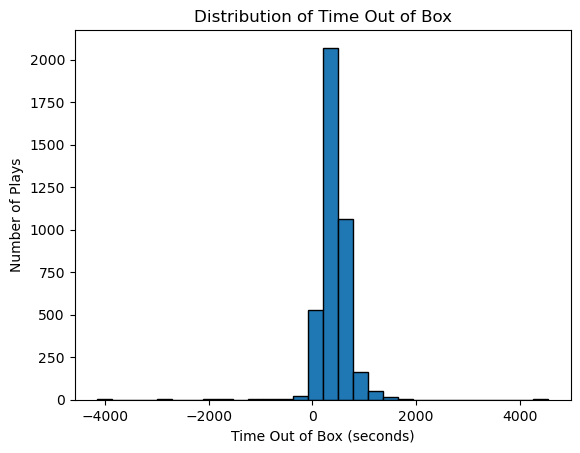

In [208]:
plt.hist(summary_df['time_out_of_box'], bins=30, edgecolor='black')
plt.title('Distribution of Time Out of Box')
plt.xlabel('Time Out of Box (seconds)')
plt.ylabel('Number of Plays')
plt.show()

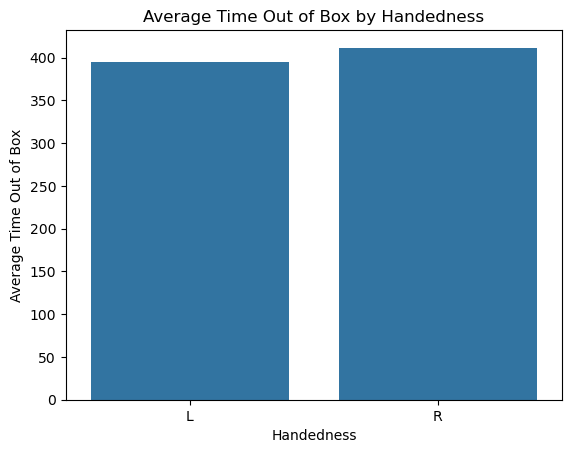

In [209]:
avg_times = summary_df.groupby('handedness')['time_out_of_box'].mean().reset_index()
sns.barplot(data=avg_times, x='handedness', y='time_out_of_box')
plt.title('Average Time Out of Box by Handedness')
plt.xlabel('Handedness')
plt.ylabel('Average Time Out of Box')
plt.show()


In [210]:
play_counts = summary_df['batter'].value_counts()
eligible_batters = play_counts[play_counts >= 10].index
filtered_df = summary_df[summary_df['batter'].isin(eligible_batters)]

player_stats = filtered_df.groupby('batter')['time_out_of_box'].agg(
    average_time='mean',
    percentile_90=lambda x: x.quantile(0.9),
    num_plays='count'
).reset_index()

print(player_stats)



      batter  average_time  percentile_90  num_plays
0   DYE-0089    394.833333          541.2         12
1   DYE-0122    378.500000          590.0         12
2   DYE-0130    441.461538          750.0         13
3   MRJ-1291    395.000000          615.0         10
4   OXG-0079    493.000000          785.0         12
..       ...           ...            ...        ...
69  YJD-0366    453.777778          750.0         36
70  YJD-0373    368.060000          629.3         50
71  YJD-0397    346.444444          720.0         27
72  YJD-0398    479.090909          650.0         11
73  YJD-0405    466.307692          820.0         13

[74 rows x 4 columns]


In [211]:
fastest_players = player_stats.sort_values('average_time').reset_index(drop=True)
print(fastest_players.head(10))

     batter  average_time  percentile_90  num_plays
0  QEA-0027    263.363636          600.0         22
1  QEA-0180    293.000000          500.0         15
2  QEA-0071    297.500000          475.0         20
3  RZQ-0385    311.000000          490.0         13
4  YJD-0019    311.133333          605.0         30
5  YJD-0210    313.333333          400.0         21
6  RZQ-0231    318.509434          500.0         53
7  RZQ-0279    321.700000          502.8         20
8  RZQ-0258    326.315789          510.0         19
9  RZQ-0310    332.434783          625.0         46
